In [4]:
!pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 9.1 MB/s eta 0:00:00


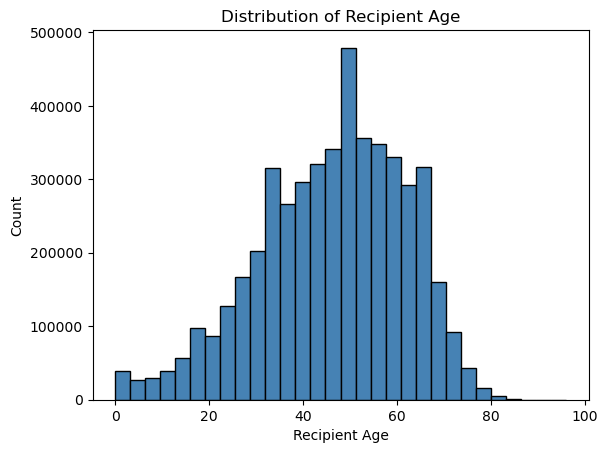

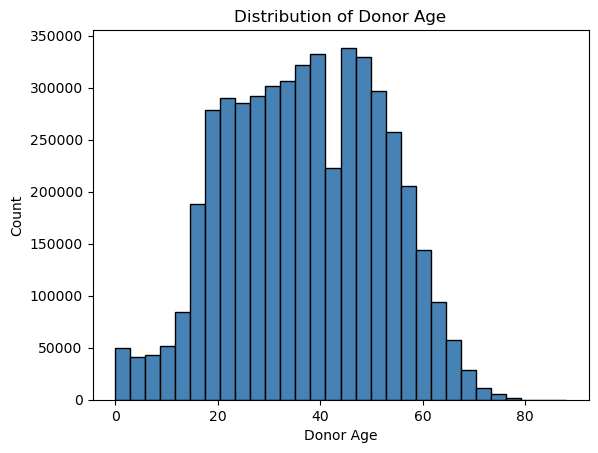

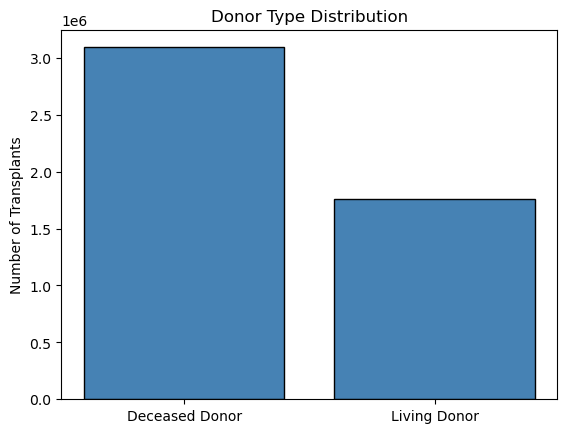

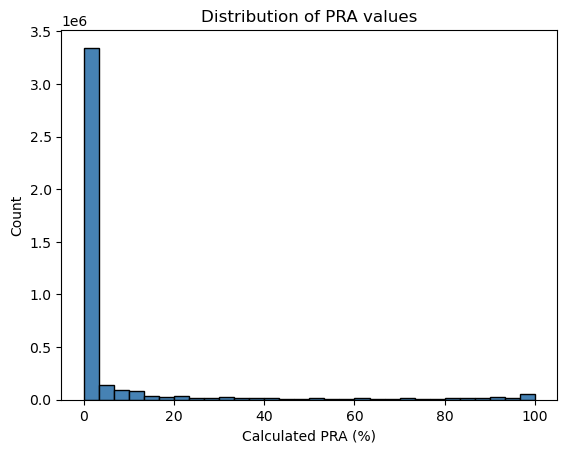

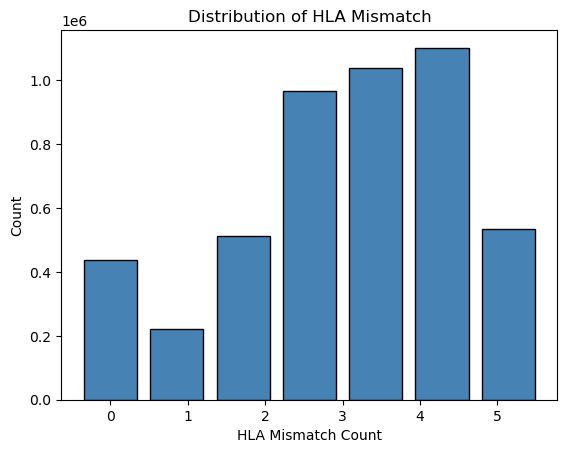

Logistic Regression Performance:
  Accuracy:  0.654
  Precision: 0.579
  Recall:    0.747
  F1-score:  0.652
  ROC AUC:   0.714

Coefficients (feature impact):
DonorHxDiabetes        2.109521
Donor_Living           1.573238
DonorHxHypertension    0.876082
Donor_DCD              0.786432
Prev_Transplant        0.318330
Race_9                 0.212005
HLA_Mismatch           0.076126
Recipient_Age          0.010826
DonorAge               0.000213
DonorGender            0.000000
dtype: float64
Recipient_Sex        0.000000
Cold_Ischemia_hrs   -0.001662
PRA                 -0.011710
Race_998            -0.038010
Race_4              -0.317835
Race_2              -0.377684
Race_6              -0.394421
Race_5              -0.427939
Race_7              -0.437161
Race_1              -0.581547
dtype: float64

Decision Tree Performance:
  Accuracy:  0.709
  Precision: 0.666
  Recall:    0.664
  F1-score:  0.665
  ROC AUC:   0.789

Top Decision Tree Feature Importances:
PRA                    0.30

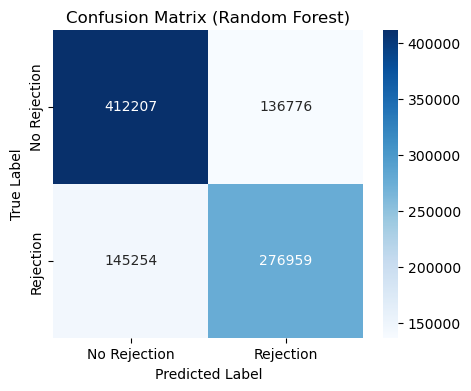


Confusion Matrix (Random Forest):
 [[412207 136776]
 [145254 276959]]
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0      0.739     0.751     0.745    548983
           1      0.669     0.656     0.663    422213

    accuracy                          0.710    971196
   macro avg      0.704     0.703     0.704    971196
weighted avg      0.709     0.710     0.709    971196



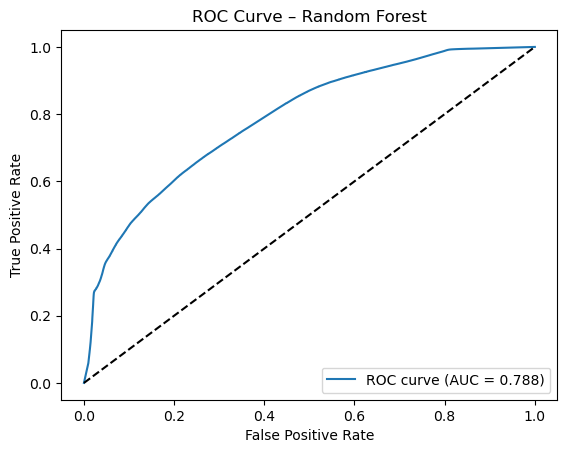

In [ ]:
# Kidney Transplant Acute Rejection Prediction
# ---------------------------------------------------
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # SHAP for model explainability (ensure shap is installed in the environment)

# 1. Load and Merge Data
# (Update file paths as needed for your environment)
df_followup   = pd.read_sas('KIDNEY_FOLLOWUP_DATA.sas7bdat', format='sas7bdat')
df_transplant = pd.read_sas('KIDPAN_DATA.sas7bdat', format='sas7bdat')
df_deceased   = pd.read_sas('DECEASED_DONOR_DATA.sas7bdat', format='sas7bdat')
df_living     = pd.read_sas('LIVING_DONOR_DATA.sas7bdat', format='sas7bdat')

# Merge follow-up and transplant records (inner join to include only transplants with follow-up data)
df = pd.merge(df_followup, df_transplant, how='inner', on='TRR_ID_CODE')

# (Optional) If multiple follow-up records per patient, filter to 1-year post-transplant follow-up:
# e.g., if there's a field 'FOLLOWUP_YRS' indicating years since transplant, one could select df = df[df['FOLLOWUP_YRS'] == 1]
# Here we assume each patient has a follow-up record around the 1-year mark.

# Merge in donor data (deceased and living donors)
# Select essential donor columns for each donor type
dec_cols = ['DONOR_ID', 'AGE_DON', 'GENDER_DON', 'HIST_HYPERTENS_DON', 'HIST_DIABETES_DON', 'NON_HRT_DON']
liv_cols = ['DONOR_ID', 'AGE_DON', 'GENDER', 'HIST_HYPER', 'DIABETES']
dec_donor_subset = df_deceased[dec_cols].copy()
liv_donor_subset = df_living[liv_cols].copy()
# Rename columns for consistency
dec_donor_subset.rename(columns={
    'AGE_DON': 'DonorAge',
    'GENDER_DON': 'DonorGender',
    'HIST_HYPERTENS_DON': 'DonorHxHypertension',
    'HIST_DIABETES_DON': 'DonorHxDiabetes',
    'NON_HRT_DON': 'Donor_DCD'  # Non-heart-beating donor (DCD) flag for deceased donors
}, inplace=True)
liv_donor_subset.rename(columns={
    'AGE_DON': 'DonorAge',
    'GENDER': 'DonorGender',
    'HIST_HYPER': 'DonorHxHypertension',
    'DIABETES': 'DonorHxDiabetes'
}, inplace=True)
# Add a flag for living vs deceased
dec_donor_subset['Donor_Living'] = 0  # 0 for deceased donor
liv_donor_subset['Donor_Living'] = 1  # 1 for living donor
# For living donors, Donor_DCD does not apply (set to 0 for all living donors)
liv_donor_subset['Donor_DCD'] = 0
# Combine donor subsets and merge into main DataFrame
donor_subset = pd.concat([dec_donor_subset, liv_donor_subset], ignore_index=True)
df = df.merge(donor_subset, how='left', on='DONOR_ID')

# 2. Feature Engineering
# Create the outcome variable for acute rejection (any acute rejection episodes recorded)
df['Rejection'] = (df['ACUTE_REJ_EPI'] >= 1).astype(int)  # 1 if at least one acute rejection episode, else 0

# Compute Panel Reactive Antibody (PRA) percentage – a measure of recipient sensitization 
df['PRA'] = pd.to_numeric(df['END_CPRA_DETAIL'], errors='coerce')  # use ending (latest) PRA value
if 'PEAK_PRA' in df.columns:
    # If peak PRA is available, use it for missing values (peak PRA might capture highest sensitization)
    df['PRA'] = df['PRA'].fillna(df['PEAK_PRA'])

# Calculate total HLA mismatches between donor and recipient
df['HLA_Mismatch'] = pd.to_numeric(df['HLAMIS'], errors='coerce')  # number of HLA mismatches (0-6 for kidney)

# Flag if the patient had any prior transplant (which could increase immunological risk)
df['Prev_Transplant'] = (df['NUM_PREV_TX'] > 0).astype(int)

# Clean up donor medical history flags (history of hypertension/diabetes in donor) to binary
# In datasets, these might be coded as 'Y'/'N' or numeric codes. We map any form of "yes/positive history" to 1, else 0.
df['DonorHxHypertension'] = df['DonorHxHypertension'].map(lambda x: 1 if x in [1, 2, 3, 4, 5, 'Y', b'Y'] else 0)
df['DonorHxDiabetes']     = df['DonorHxDiabetes'].map(lambda x: 1 if x in [1, 2, 3, 4, 5, 'Y', b'Y'] else 0)

# Convert ages and genders to numeric fields
df['Recipient_Age'] = pd.to_numeric(df['AGE'], errors='coerce')
# Map recipient gender to 0/1 (Female=0, Male=1)
df['Recipient_Sex'] = df['GENDER'].map({'F': 0, 'M': 1, 'Female': 0, 'Male': 1}).fillna(0).astype(int)
# Map donor gender to 0/1 (Female=0, Male=1)
df['DonorGender'] = df['DonorGender'].map({'F': 0, 'M': 1, 'Female': 0, 'Male': 1}).fillna(0).astype(int)

# Cold ischemia time (in hours) for the transplanted kidney – prolonged preservation time can affect outcomes
if 'COLD_ISCH_KI' in df.columns:
    df['Cold_Ischemia_hrs'] = pd.to_numeric(df['COLD_ISCH_KI'], errors='coerce').fillna(0)
else:
    df['Cold_Ischemia_hrs'] = 0  # if not available (e.g., living donor kidneys usually have minimal cold ischemia)

# Ensure Donor_DCD (donation after cardiac death) is binary 0/1
if 'Donor_DCD' in df.columns:
    df['Donor_DCD'] = df['Donor_DCD'].map(lambda x: 1 if x in [1, 'Y', b'Y'] else 0)

# One-hot encode recipient ethnicity/race (to account for any demographic effects)
eth = df['ETHCAT'].fillna(998).astype(int)  # use 998 as code for missing/unknown (per data dictionary)
race_dummies = pd.get_dummies(eth, prefix='Race')
df = pd.concat([df, race_dummies], axis=1)

# 3. Select Features for Modeling
# We choose features known to be medically relevant to rejection risk:
# - Recipient factors: age, sex, race/ethnicity, prior transplant, PRA (sensitization level), HLA mismatches.
# - Donor factors: donor age, donor sex, living vs deceased donor, DCD status (if deceased donor was non-heart-beating), 
#                 donor history of hypertension/diabetes (proxy for organ quality), cold ischemia time.
features = [
    'Recipient_Age', 'Recipient_Sex', 'DonorAge', 'DonorGender', 'Donor_Living', 'Donor_DCD',
    'DonorHxHypertension', 'DonorHxDiabetes', 'HLA_Mismatch', 'PRA', 'Prev_Transplant', 'Cold_Ischemia_hrs'
] + list(race_dummies.columns)  # include all race dummy columns
X = df[features]
y = df['Rejection']

# 4. Data Cleaning & Preparation
# Convert all feature columns to numeric type (some might still be objects due to missing or categorical codes)
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values by imputing or filling. We'll impute continuous features with the mean.
float_cols = X.select_dtypes(include=['float64', 'float32']).columns
imputer = SimpleImputer(strategy='mean')
X[float_cols] = imputer.fit_transform(X[float_cols])
# For any remaining NaNs in other columns (e.g., if any categorical dummy was NaN), fill with 0 (reasonable for flags).
X.fillna(0, inplace=True)

# 5. Train-Test Split (with stratification to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Stratified split ensures similar rejection vs non-rejection ratio in train and test sets.

# 6. Exploratory Data Analysis – Feature Distributions
# (Plot distributions of key features to understand the data; these plots are for exploratory insight.)
plt.figure()
plt.hist(df['Recipient_Age'].dropna(), bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Recipient Age'); plt.ylabel('Count'); plt.title('Distribution of Recipient Age')
plt.show()

plt.figure()
plt.hist(df['DonorAge'].dropna(), bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Donor Age'); plt.ylabel('Count'); plt.title('Distribution of Donor Age')
plt.show()

plt.figure()
# Bar plot for living vs deceased donor count
donor_type_counts = df['Donor_Living'].value_counts()  # 0 = deceased, 1 = living
plt.bar([0, 1], donor_type_counts.loc[[0, 1]], color='steelblue', edgecolor='black')
plt.xticks([0, 1], ['Deceased Donor', 'Living Donor'])
plt.ylabel('Number of Transplants'); plt.title('Donor Type Distribution')
plt.show()

plt.figure()
plt.hist(df['PRA'].dropna(), bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Calculated PRA (%)'); plt.ylabel('Count'); plt.title('Distribution of PRA values')
plt.show()

plt.figure()
plt.hist(df['HLA_Mismatch'].dropna(), bins=7, align='left', rwidth=0.8, color='steelblue', edgecolor='black')
plt.xlabel('HLA Mismatch Count'); plt.ylabel('Count'); plt.title('Distribution of HLA Mismatch')
plt.show()

# (After EDA, we proceed to modeling. The plots above give a sense of data spread; e.g., age ranges, PRA distribution, etc.)

# 7. Model Training and Evaluation

# a. Logistic Regression ( interpretable linear model )
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
# class_weight='balanced' to handle class imbalance by penalizing minority class more
log_reg.fit(X_train, y_train)

# Predictions and probabilities
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_lr):.3f}")
print(f"  Recall:    {recall_score(y_test, y_pred_lr):.3f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_lr):.3f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_proba_lr):.3f}")
print("\nCoefficients (feature impact):")
coef_values = pd.Series(log_reg.coef_[0], index=X_train.columns)
# Display the top positive and negative coefficients
print(coef_values.sort_values(ascending=False).head(10))   # top 10 features increasing rejection risk
print(coef_values.sort_values(ascending=False).tail(10))   # features that decrease risk (negative coefficients)

# b. Decision Tree (simple interpretable tree model)
tree_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=None, random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

# Evaluate Decision Tree
print("\nDecision Tree Performance:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_tree):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_tree):.3f}")
print(f"  Recall:    {recall_score(y_test, y_pred_tree):.3f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_tree):.3f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_proba_tree):.3f}")
# Feature importance of the tree (which features the tree found most informative)
importances = pd.Series(tree_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop Decision Tree Feature Importances:")
print(importances.head(10))

# (Optional) Visualize the Decision Tree structure for interpretability
# Uncomment below to plot the tree (may be large if tree is deep)
# plt.figure(figsize=(12, 8))
# plot_tree(tree_clf, feature_names=X_train.columns, class_names=["NoRej", "Rej"], filled=True, max_depth=3)
# plt.title("Decision Tree (partial) - top 3 levels")
# plt.show()

# c. Random Forest (ensemble of trees) with GridSearchCV for hyperparameter tuning
# Define a small parameter grid for tuning (to keep it computationally manageable)
param_grid = {
    'n_estimators': [50, 100],   # number of trees in the forest
    'max_depth': [None, 5, 10]   # maximum depth of each tree (None means no limit)
}
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf_base, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nRandom Forest Grid Search Best Params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
print("\nRandom Forest Performance (Best Model):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"  Recall:    {recall_score(y_test, y_pred_rf):.3f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_rf):.3f}")
print(f"  ROC AUC:   {roc_auc_score(y_test, y_proba_rf):.3f}")

# Feature importance from Random Forest
rf_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop Random Forest Feature Importances:")
print(rf_importances.head(10))

# 8. Performance Visualization
# Confusion matrix for the Random Forest model
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Rejection', 'Rejection'], 
            yticklabels=['No Rejection', 'Rejection'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()
print("\nConfusion Matrix (Random Forest):\n", cm)
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, digits=3))

# ROC Curve for the Random Forest model
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line for random chance
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend(loc="lower right")
plt.show()

# 9. Model Explainability with SHAP
# Use SHAP values to explain the Random Forest predictions
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)  # SHAP values for each class (0 and 1)

# Plot SHAP summary for the positive class (class 1: rejection)
plt.figure()
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns)
plt.title("SHAP Summary Plot for Random Forest (Rejection class)")
plt.show()

# The SHAP summary plot shows the most influential features for predicting rejection.
# Positive SHAP value = feature contributes to higher rejection risk; negative = contributes to no-rejection.
